# EV Charging Load Modeling

This notebook explores EV Charging Load Modeling and Prediction. It It develops the following models: 

- Bayesian linear model using PyMC
- Random Forest model using scikit-learn
- TODO: Gaussian Process Regression

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import numpy as np

In [3]:
sns.set_theme()

In [4]:
raw_data = pd.read_csv("../data/Electric_Vehicle_Charging_Station_Data.csv")

In [5]:
raw_data

,ObjectId2,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,End_Time_Zone,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,Port_Type,ObjectID
0,1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/1/2018 17:49,MDT,1/1/2018 19:52,MDT,2:03:02,2:02:44,6.504,2.732,0.816,Level 2,0
1,2,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 8:52,MDT,1/2/2018 9:16,MDT,0:24:34,0:24:19,2.481,1.042,0.311,Level 2,1
2,3,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,1/2/2018 21:11,MDT,1/3/2018 6:23,MDT,9:12:21,3:40:52,15.046,6.319,1.888,Level 2,2
3,4,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,1/3/2018 9:19,MDT,1/3/2018 11:14,MDT,1:54:51,1:54:29,6.947,2.918,0.872,Level 2,3
4,5,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,1/3/2018 14:13,MDT,1/3/2018 14:30,MDT,0:16:58,0:16:44,1.800,0.756,0.226,Level 2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70189,70190,MUNICIPAL SC / 1100WALNUT1,1100 Walnut,Boulder,Colorado,80302,2023-08-31 09:20:52,MDT,2023-08-31 10:56:11,MDT,01:35:13,00:49:39,2.360,1.675,0.296,Level 2,70125
70190,70191,MUNICIPAL SC / 1104 SPRUCE1,1100 Spruce St,Boulder,Colorado,80302,2023-08-31 09:24:16,MDT,2023-08-31 10:26:58,MDT,01:02:42,01:02:28,6.277,4.457,0.788,Level 2,70126
70191,70192,BOULDER / ATRIUM ST1,1770 13th St,Boulder,Colorado,80302,2023-08-31 09:39:36,MDT,2023-08-31 11:48:55,MDT,02:09:22,02:09:08,12.933,9.183,1.623,Level 2,70127
70192,70193,BOULDER / REC CENTER ST2,1360 Gillaspie Dr,Boulder,Colorado,80305,2023-08-31 09:41:08,MDT,2023-08-31 10:55:27,MDT,01:14:21,01:14:09,7.512,5.334,0.943,Level 2,70128


In [6]:
raw_data.describe()

,ObjectId2,Zip_Postal_Code,Energy__kWh_,GHG_Savings__kg_,Gasoline_Savings__gallons_,ObjectID
count,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000,70194.000000
mean,35097.500000,80302.573724,8.450916,5.258133,1.060591,35096.500000
std,20263.406735,1.108910,8.807785,5.919214,1.105376,20263.406735
min,1.000000,80301.000000,0.000000,0.000000,0.000000,0.000000
25%,17549.250000,80302.000000,2.842250,1.597000,0.357000,17548.250000
50%,35097.500000,80302.000000,6.240000,3.676500,0.783000,35096.500000
75%,52645.750000,80303.000000,11.373000,6.851000,1.427000,52644.750000
max,70194.000000,80305.000000,92.691000,65.811000,11.633000,70193.000000


In [7]:
raw_data.columns

Index(['ObjectId2', 'Station_Name', 'Address', 'City', 'State_Province',
       'Zip_Postal_Code', 'Start_Date___Time', 'Start_Time_Zone',
       'End_Date___Time', 'End_Time_Zone', 'Total_Duration__hh_mm_ss_',
       'Charging_Time__hh_mm_ss_', 'Energy__kWh_', 'GHG_Savings__kg_',
       'Gasoline_Savings__gallons_', 'Port_Type', 'ObjectID'],
      dtype='object')

In [8]:
df = raw_data.copy()

# Convert your start and end times to datetime, ensuring correct timezone handling if necessary
df['Start_Date___Time'] = pd.to_datetime(df['Start_Date___Time'], format='mixed')
df['End_Date___Time'] = pd.to_datetime(df['End_Date___Time'], format='mixed')

display(df.isnull().sum())

df = df.dropna()

ObjectId2                     0
Station_Name                  0
Address                       0
City                          0
State_Province                0
Zip_Postal_Code               0
Start_Date___Time             0
Start_Time_Zone               0
End_Date___Time               2
End_Time_Zone                 0
Total_Duration__hh_mm_ss_     0
Charging_Time__hh_mm_ss_      0
Energy__kWh_                  0
GHG_Savings__kg_              0
Gasoline_Savings__gallons_    0
Port_Type                     0
ObjectID                      0
dtype: int64

In [9]:
# Function to distribute charging session energy hourly
def distribute_energy_hourly(row):
    # Generate a date range for each hour the charging session covers
    start_hour = row['Start_Date___Time'].floor('H')
    end_hour = (row['End_Date___Time'] + pd.Timedelta(hours=1)).floor('H')
    hours = pd.date_range(start=start_hour, end=end_hour, freq='H')

    total_hours = (row['End_Date___Time'] - row['Start_Date___Time']).total_seconds() / 3600.0
    energy_per_hour = row['Energy__kWh_'] / total_hours if total_hours else 0 
    hourly_data = pd.DataFrame({'hour_date': hours[:-1], 'kWh': energy_per_hour})

    # The last hour energy may not be a full hour
    if hours.size > 1:
        last_hour_fraction = (row['End_Date___Time'] - hours[-2]).total_seconds() / 3600.0
        hourly_data.loc[hourly_data.index[-1], 'kWh'] *= last_hour_fraction
    
    # If there is only one hour, adjust energy based on the portion of the hour during which charging occurred
    if hours.size == 1:
        only_hour_fraction = (row['End_Date___Time'] - row['Start_Date___Time']).total_seconds() / 3600.0
        hourly_data.loc[0, 'kWh'] = row['Energy__kWh_'] * only_hour_fraction
    
    return hourly_data

In [10]:
# Apply the function to each row and concatenate the results
hourly_contributions = pd.concat([distribute_energy_hourly(row) for index, row in df.iterrows()], ignore_index=True)
# Group by the hour and sum up the energy for that hour
hourly_energy_demand = hourly_contributions.groupby(hourly_contributions['hour_date']).sum().reset_index()

print(hourly_energy_demand)

                hour_date       kWh
0     2018-01-01 17:00:00  3.172683
1     2018-01-01 18:00:00  3.172683
2     2018-01-01 19:00:00  2.749659
3     2018-01-02 08:00:00  6.202500
4     2018-01-02 09:00:00  1.654000
...                   ...       ...
47047 2023-09-05 11:00:00  0.021090
47048 2023-09-05 12:00:00  0.021090
47049 2023-09-05 13:00:00  0.021090
47050 2023-09-05 14:00:00  0.021090
47051 2023-09-05 15:00:00  0.000176

[47052 rows x 2 columns]


In [11]:
hourly_energy_demand["hour"] = hourly_energy_demand["hour_date"].dt.hour
hourly_energy_demand["day"] = hourly_energy_demand["hour_date"].dt.dayofweek
hourly_energy_demand["year"] = hourly_energy_demand["hour_date"].dt.year
year_idx, years = pd.factorize(hourly_energy_demand["year"])
hourly_energy_demand["year_idx"] = year_idx
hourly_energy_demand

,hour_date,kWh,hour,day,year,year_idx
0,2018-01-01 17:00:00,3.172683,17,0,2018,0
1,2018-01-01 18:00:00,3.172683,18,0,2018,0
2,2018-01-01 19:00:00,2.749659,19,0,2018,0
3,2018-01-02 08:00:00,6.202500,8,1,2018,0
4,2018-01-02 09:00:00,1.654000,9,1,2018,0
...,...,...,...,...,...,...
47047,2023-09-05 11:00:00,0.021090,11,1,2023,5
47048,2023-09-05 12:00:00,0.021090,12,1,2023,5
47049,2023-09-05 13:00:00,0.021090,13,1,2023,5
47050,2023-09-05 14:00:00,0.021090,14,1,2023,5


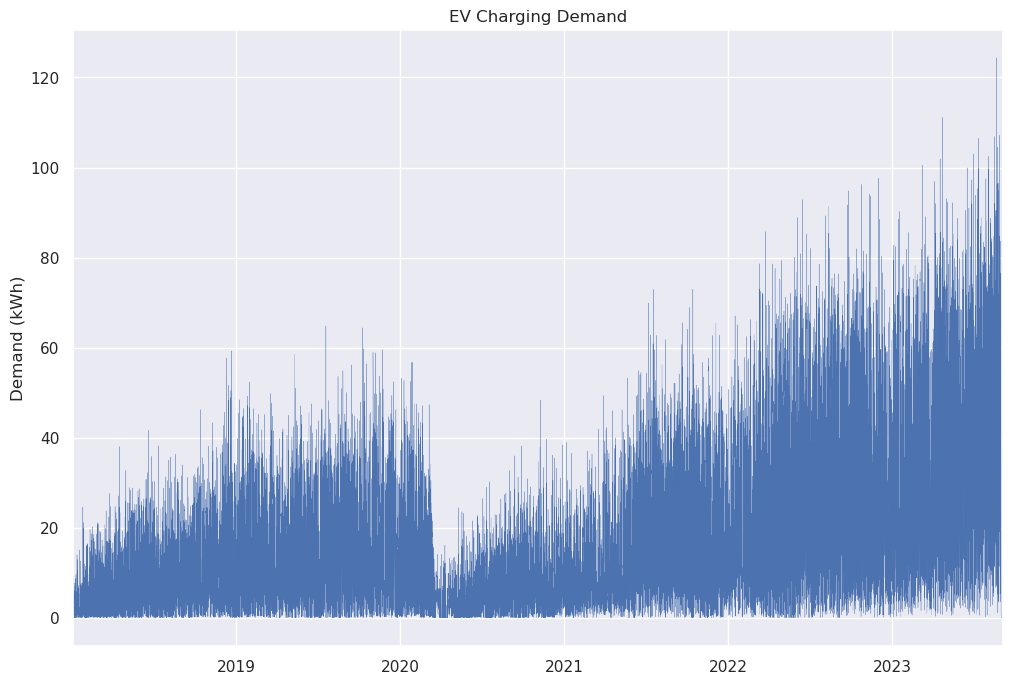

In [162]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(hourly_energy_demand.hour_date, hourly_energy_demand.kWh, linewidth=.2)

ax.set_title("EV Hourly Charging Demand")
ax.set_ylabel("Demand (kWh)")
ax.set_xmargin(0)

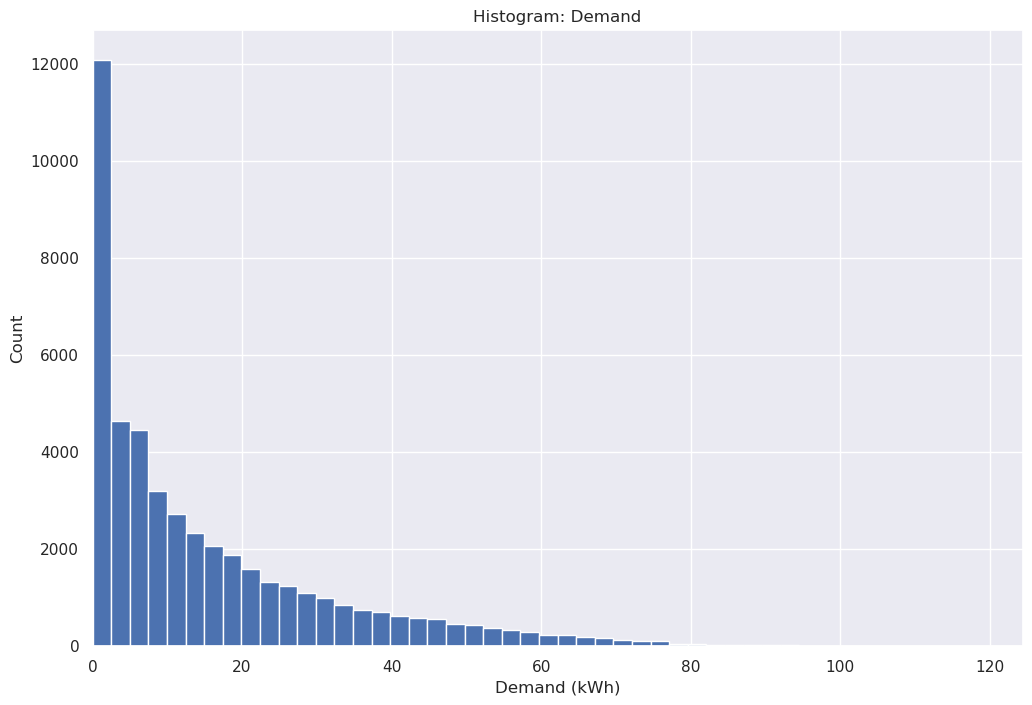

In [163]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(hourly_energy_demand.kWh, bins=50)

ax.set_title("Histogram: Demand")
ax.set_ylabel("Count")
ax.set_xlabel("Demand (kWh)")
ax.set_xmargin(0)

In [15]:
X = hourly_energy_demand.copy()
X["kWh_std"] = (X["kWh"] - X["kWh"].mean()) / X["kWh"].std()

X

,hour_date,kWh,hour,day,year,year_idx,kWh_std
0,2018-01-01 17:00:00,3.172683,17,0,2018,0,-0.714852
1,2018-01-01 18:00:00,3.172683,18,0,2018,0,-0.714852
2,2018-01-01 19:00:00,2.749659,19,0,2018,0,-0.739310
3,2018-01-02 08:00:00,6.202500,8,1,2018,0,-0.539680
4,2018-01-02 09:00:00,1.654000,9,1,2018,0,-0.802657
...,...,...,...,...,...,...,...
47047,2023-09-05 11:00:00,0.021090,11,1,2023,5,-0.897065
47048,2023-09-05 12:00:00,0.021090,12,1,2023,5,-0.897065
47049,2023-09-05 13:00:00,0.021090,13,1,2023,5,-0.897065
47050,2023-09-05 14:00:00,0.021090,14,1,2023,5,-0.897065


In [16]:
len(years)

6

In [17]:
coords = {
    "year": np.arange(len(years)),
    "hour": np.arange(24),
    "day": np.arange(7),
}

## Model: Hour, day, year

Given:
- $ \alpha $: Intercept
- $ \beta_i $: Effect of the i-th hour of the day (for $ i = 1, 2, ..., 24 $)
- $ \gamma_j $: Effect of the j-th day of the week (for $ j = 1, 2, ..., 7 $)
- $ \delta_k $: Effect of the k-th year (for $ k = 0, 1, ..., 6 $)
- $ \mu $: Expected kWh charged for a given hour and day
- $ \sigma $: Standard deviation of the observations
- $ Y $: Observed kWh charged (standardized)

The model can be represented as:

1. Prior on the intercept:
$$ \alpha \sim \mathcal{N}(0, 1) $$

2. Priors on the hourly effects:
$$ \beta_i \sim \mathcal{N}(0, 1) \quad \text{for} \quad i = 1, 2, ..., 24 $$

3. Priors on the daily effects:
$$ \gamma_j \sim \mathcal{N}(0, 1) \quad \text{for} \quad j = 1, 2, ..., 7 $$

4. Priors on the yearly effects:

$$ \delta_k \sim \mathcal{N}(0, 1) \quad \text{for} \quad k = 1, 2, ..., 6 $$

5. Prior on the standard deviation:
$$ \sigma \sim \text{HalfNormal}(1) $$

6. The linear model for the expected kWh charged given hour and day:
$$ \mu = \alpha + \beta_{X_{\text{hour}}} + \gamma_{X_{\text{day}}} + \delta_{X_{\text{year}}} $$

7. The likelihood of the observed data:
$$ Y \sim \mathcal{N}(\mu_i, \sigma) $$


In [167]:
with pm.Model(coords=coords) as model:
    alpha = pm.Normal("alpha", 0, 1)
    # hour of day
    beta = pm.Normal("beta", 0, 1, dims="hour")
    # day of week
    gamma = pm.Normal("gamma", 0, 1, dims="day")
    # year
    delta = pm.Normal("delta", 0, 1, dims="year")
    
    mu = alpha + beta[X.hour] + gamma[X.day] + delta[X.year_idx]
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=X.kWh_std)

In [168]:
with model:
    idata = pm.sample(tune=2000, draws=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 2115 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

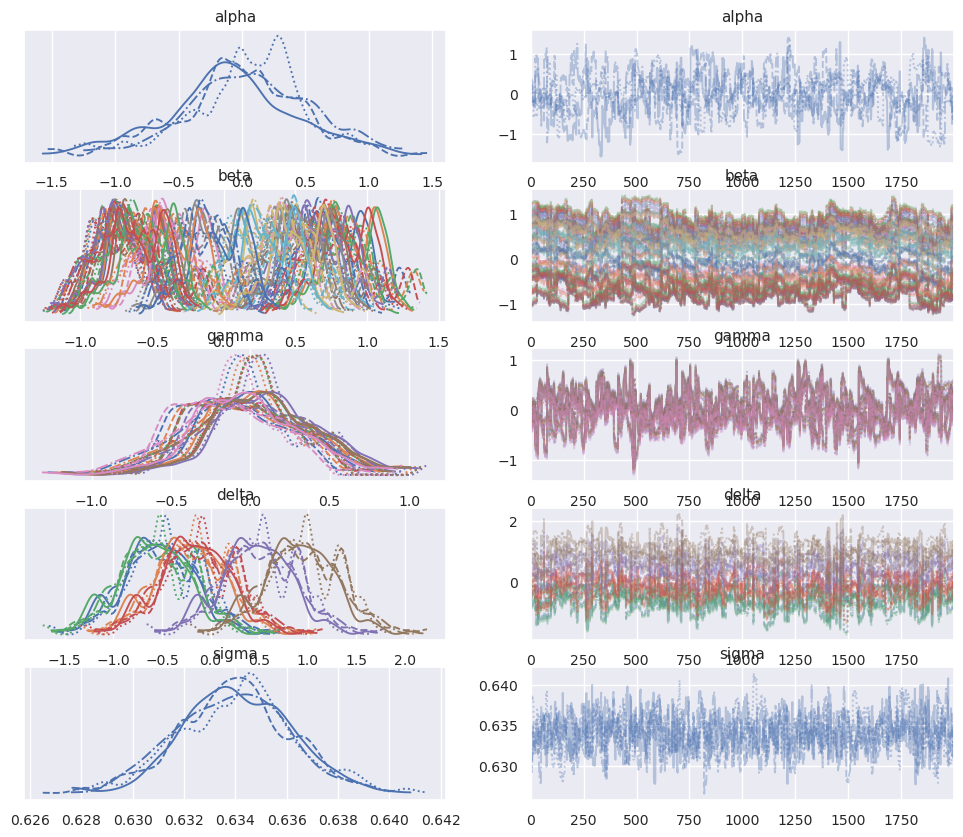

In [169]:
az.plot_trace(idata)

In [170]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    pm.compute_log_likelihood(idata, extend_inferencedata=True)

Sampling: [Y_obs]


In [171]:
az.waic(idata)

Computed from 8000 posterior samples and 47052 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -45344.53   213.60
p_waic       37.32        -

In [172]:
az.loo(idata)

/home/cjirmas/miniforge3/envs/ev-analysis/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 8000 posterior samples and 47052 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -45344.58   213.60
p_loo       37.37        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     47052  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [173]:
Y_obs = idata.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse = np.sqrt(np.mean((Y_obs - X.kWh_std)**2))*X.kWh.std()

print(f"RMSE: {rmse} kWh")

RMSE: 10.963897792442214 kWh


In [174]:
r2 = az.r2_score(X.kWh_std, Y_obs)

r2

r2        0.598121
r2_std    0.000000
dtype: float64

## Model: Hierarchical (pooled hourly/daily)

This model implements partial pooling, grouping on hourly and daily effects.

Given:
- $ \alpha $: Intercept
- $ \beta_i $: Effect of the i-th hour of the day (for $ i = 1, 2, ..., 24 $)
- $ \gamma_j $: Effect of the j-th day of the week (for $ j = 1, 2, ..., 7 $)
- $ \delta_k $: Effect of the k-th year (for $ j = 1, 2, ..., 6 $)
- $ \mu $: Expected kWh charged for a given hour, day, year
- $ \sigma $: Standard deviation of the observations
- $ \sigma_{\beta} $: Standard deviation of the hourly effects
- $ \sigma_{\gamma} $: Standard deviation of the daily effects
- $ Y $: Observed kWh charged (standardized)

The model can be represented as:

1. Prior on the intercept:
$$ \alpha \sim \mathcal{N}(0, 1) $$

2. Priors on the hourly effects:
$$ \beta_i \sim \mathcal{N}(0, \sigma_{\beta}) \quad \text{for} \quad i = 1, 2, ..., 24 $$

3. Priors on the daily effects:
$$ \gamma_j \sim \mathcal{N}(0, \sigma_{\gamma}) \quad \text{for} \quad j = 1, 2, ..., 7 $$

4. Priors on the yearly effects:

$$ \delta_k \sim \mathcal{N}(0, 1) \quad \text{for} \quad j = 1, 2, ..., 6 $$

6. Prior on the standard deviation:
$$ \sigma \sim \text{HalfNormal}(1) $$

7. Hyperpriors:

$$ \sigma_{\beta} \sim \text{Exponential}(1) $$
$$ \sigma_{\gamma} \sim \text{Exponential}(1) $$

6. The linear model for the expected kWh charged given hour and day:
$$ \mu = \alpha + \beta_{X_{\text{hour}}} + \gamma_{X_{\text{day}}} + \delta_{X_{\text{year}}} $$

7. The likelihood of the observed data:
$$ Y \sim \mathcal{N}(\mu, \sigma) $$

In [175]:
with pm.Model(coords=coords) as model2:
    # hyperpriors
    sigma_beta = pm.Exponential("sigma_beta", 1)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    
    # hour of day
    beta = pm.Normal("beta", 0, sigma_beta, dims="hour")
    # day of week
    gamma = pm.Normal("gamma", 0, sigma_gamma, dims="day")
    # year
    delta = pm.Normal("delta", 0, 1, dims="year")
    
    mu = beta[X.hour] + gamma[X.day] + delta[X.year_idx]
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=X.kWh_std)

In [176]:
with model2:
    idata2 = pm.sample(tune=2000, draws=2000, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_beta, sigma_gamma, beta, gamma, delta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1679 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma_gamma'}>,
        <Axes: title={'center': 'sigma_gamma'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

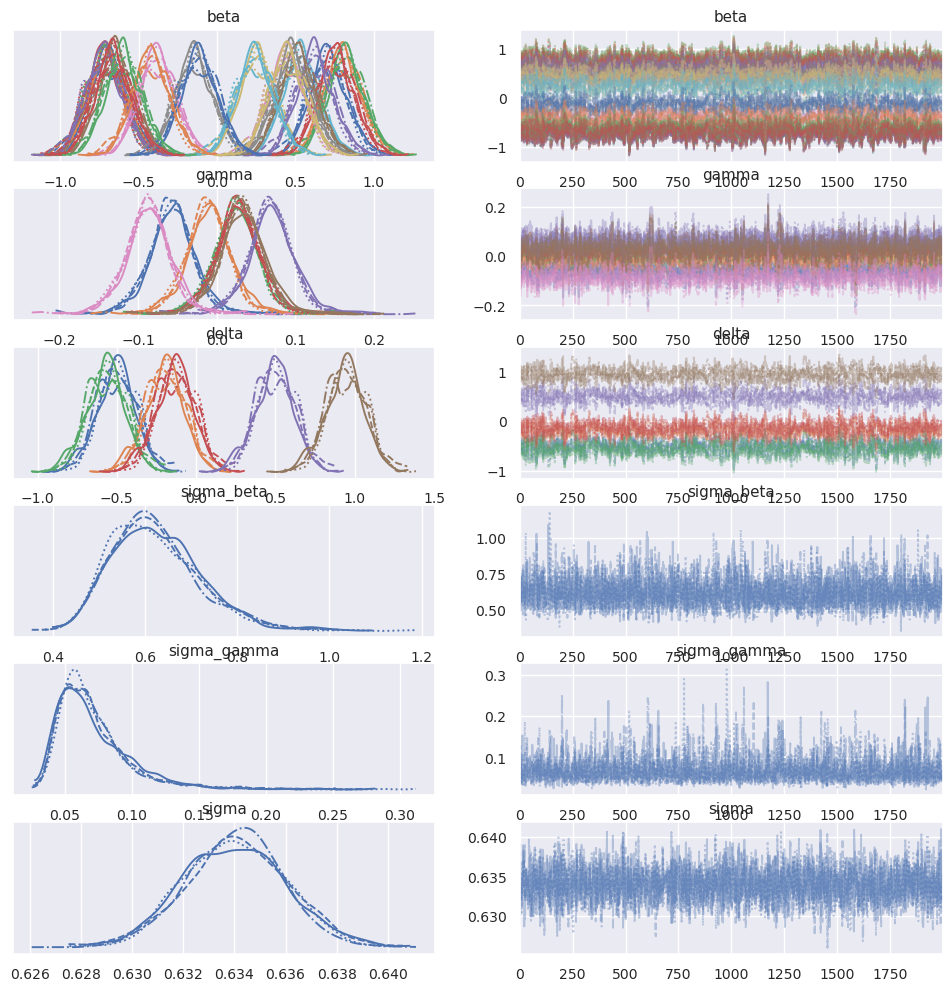

In [177]:
az.plot_trace(idata2)

In [178]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-0.695,0.123,-0.922,-0.461,0.005,0.003,718.0,939.0,1.00
beta[1],-0.705,0.123,-0.929,-0.470,0.005,0.003,725.0,1087.0,1.00
beta[2],-0.718,0.123,-0.954,-0.493,0.005,0.003,725.0,1006.0,1.00
beta[3],-0.722,0.123,-0.952,-0.494,0.005,0.003,722.0,1029.0,1.00
beta[4],-0.721,0.123,-0.949,-0.489,0.005,0.003,718.0,1009.0,1.00
beta[5],-0.646,0.123,-0.872,-0.413,0.005,0.003,723.0,990.0,1.00
beta[6],-0.383,0.123,-0.601,-0.141,0.005,0.003,727.0,973.0,1.00
beta[7],-0.145,0.123,-0.383,0.076,0.005,0.003,728.0,1068.0,1.00
beta[8],0.255,0.123,0.017,0.477,0.005,0.003,723.0,1015.0,1.01
beta[9],0.535,0.123,0.305,0.765,0.005,0.003,722.0,974.0,1.00


In [179]:
with model2:
    pm.compute_log_likelihood(idata2, extend_inferencedata=True)

In [180]:
az.waic(idata2)

Computed from 8000 posterior samples and 47052 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -45344.08   213.59
p_waic       36.70        -

In [181]:
az.loo(idata2)

Computed from 8000 posterior samples and 47052 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -45344.11   213.59
p_loo       36.73        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     47052  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [182]:
with model2:
    pm.sample_posterior_predictive(idata2, extend_inferencedata=True)

Sampling: [Y_obs]


In [183]:
Y_obs = idata2.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse2 = np.mean(np.abs(Y_obs - X.kWh_std))*X.kWh.std()

print(f"RMSE: {rmse2} kWh")

RMSE: 8.35792139764264 kWh


In [184]:
r2 = az.r2_score(X.kWh_std, Y_obs)

r2

r2        0.598086
r2_std    0.000000
dtype: float64

Text(0, 0.5, 'Hour')

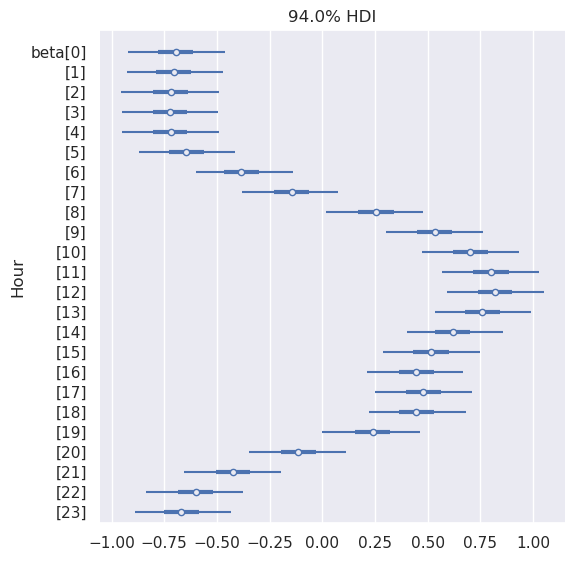

In [185]:
axes = az.plot_forest(idata2, var_names=["beta"], combined=True)
axes[0].set_ylabel("Hour")

## Model: Hierarchical (non-centered parameterization)

This model implements partial pooling on year as well. It also changes the hyperpriors to allow for more control over variation on different effects.

Given:
- $ \alpha $: Intercept
- $ \beta_i $: Effect of the i-th hour of the day (for $ i = 1, 2, ..., 24 $)
- $ \gamma_j $: Effect of the j-th day of the week (for $ j = 1, 2, ..., 7 $)
- $ \delta_k $: Effect of the k-th year (for $ j = 1, 2, ..., 6 $)
- $ \mu $: Expected kWh charged for a given hour, day, year
- $ \sigma $: Standard deviation of the observations
- $ \sigma_{\beta} $: Standard deviation of the hourly effects (hyperprior)
- $ \sigma_{\gamma} $: Standard deviation of the daily effects (hyperprior)
- $ \sigma_{\delta} $: Standard deviation of the yearly effects (hyperprior)
- $ Y $: Observed kWh charged (standardized)

The model can be represented as:

1. Prior on the intercept:
$$ \alpha \sim \mathcal{N}(0, 1) $$

2. Priors on the hourly effects:
$$ \beta_i \sim \mathcal{N}(0, 1) \quad \text{for} \quad i = 1, 2, ..., 24 $$

3. Priors on the daily effects:
$$ \gamma_j \sim \mathcal{N}(0, 1) \quad \text{for} \quad j = 1, 2, ..., 7 $$

4. Priors on the yearly effects:

$$ \delta_k \sim \mathcal{N}(0, 1) \quad \text{for} \quad j = 1, 2, ..., 6 $$

6. Prior on the standard deviation:
$$ \sigma \sim \text{HalfNormal}(1) $$

7. Hyperpriors:

$$ \sigma_{\beta} \sim \text{HalfCauchy}(.5) $$
$$ \sigma_{\gamma} \sim \text{Exponential}(1) $$
$$ \sigma_{\delta} \sim \text{Gamma}(1, 2) $$

6. The linear model for the expected kWh charged given hour and day:
$$ \mu = \alpha + \beta_{X_{\text{hour}}}\sigma_{\beta} + \gamma_{X_{\text{day}}}\sigma_{\gamma} + \delta_{X_{\text{year}}}\sigma_{\delta} $$

7. The likelihood of the observed data:
$$ Y \sim \mathcal{N}(\mu, \sigma) $$

In [18]:
with pm.Model(coords=coords) as model3:
    # hyperpriors
    sigma_beta = pm.HalfCauchy("sigma_beta", .5)
    sigma_gamma = pm.Exponential("sigma_gamma", 1)
    sigma_delta = pm.Gamma("sigma_delta", 1, 2)
    
    # hour of day
    beta = pm.Normal("beta", 0, 1, dims="hour")
    # day of week
    gamma = pm.Normal("gamma", 0, 1, dims="day")
    # year
    delta = pm.Normal("delta", 0, 1, dims="year")
    
    mu = beta[X.hour]*sigma_beta + gamma[X.day]*sigma_gamma + delta[X.year_idx]*sigma_delta
    sigma = pm.HalfNormal("sigma", 1)

    obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=X.kWh_std)

In [19]:
with model3:
    idata3 = pm.sample(tune=2000, draws=2000, target_accept=.95)
    pm.compute_log_likelihood(idata3, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_beta, sigma_gamma, sigma_delta, beta, gamma, delta, sigma]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32643 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'delta'}>,
        <Axes: title={'center': 'delta'}>],
       [<Axes: title={'center': 'sigma_beta'}>,
        <Axes: title={'center': 'sigma_beta'}>],
       [<Axes: title={'center': 'sigma_gamma'}>,
        <Axes: title={'center': 'sigma_gamma'}>],
       [<Axes: title={'center': 'sigma_delta'}>,
        <Axes: title={'center': 'sigma_delta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

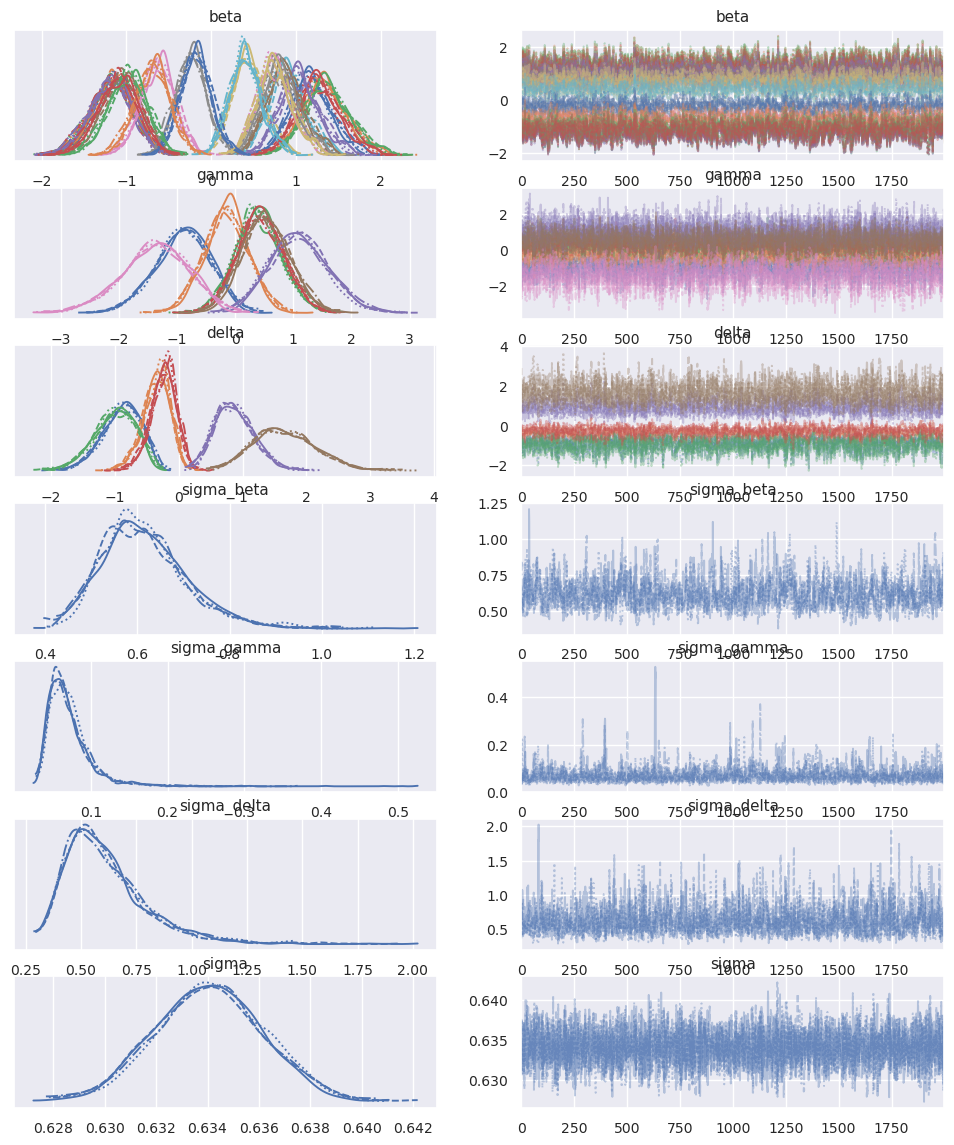

In [20]:
az.plot_trace(idata3)

In [21]:
az.summary(idata3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-1.145,0.248,-1.625,-0.695,0.009,0.006,843.0,1213.0,1.00
beta[1],-1.161,0.250,-1.624,-0.693,0.009,0.006,851.0,1263.0,1.00
beta[2],-1.184,0.252,-1.662,-0.726,0.009,0.006,844.0,1313.0,1.00
beta[3],-1.189,0.253,-1.670,-0.731,0.009,0.006,842.0,1236.0,1.00
beta[4],-1.187,0.252,-1.661,-0.728,0.009,0.006,845.0,1259.0,1.00
beta[5],-1.063,0.240,-1.509,-0.613,0.008,0.006,848.0,1272.0,1.00
beta[6],-0.626,0.204,-1.025,-0.248,0.007,0.005,839.0,1215.0,1.00
beta[7],-0.231,0.186,-0.591,0.114,0.006,0.005,839.0,1337.0,1.01
beta[8],0.434,0.192,0.083,0.811,0.007,0.005,861.0,1167.0,1.01
beta[9],0.899,0.224,0.481,1.329,0.008,0.005,865.0,1206.0,1.01


Text(0, 0.5, 'Hour')

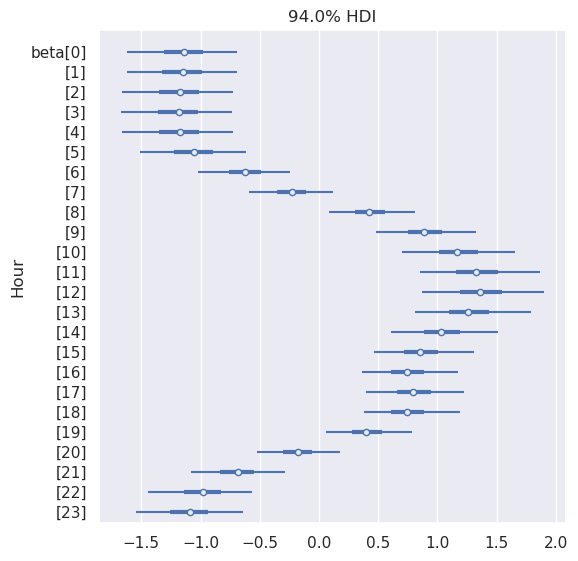

In [22]:
axes = az.plot_forest(idata3, var_names=["beta"], combined=True)
axes[0].set_ylabel("Hour")

Text(0, 0.5, 'Day')

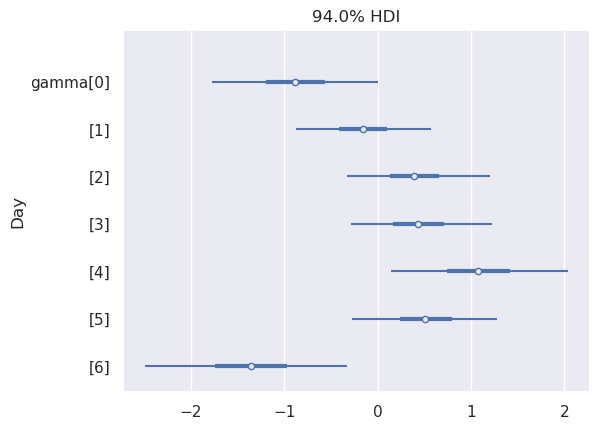

In [23]:
axes = az.plot_forest(idata3, var_names=["gamma"], combined=True)
axes[0].set_ylabel("Day")

Text(0, 0.5, 'Year')

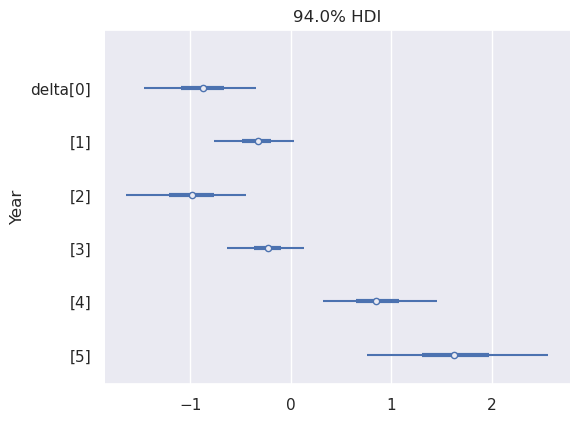

In [24]:
axes = az.plot_forest(idata3, var_names=["delta"], combined=True)
axes[0].set_ylabel("Year")

In [25]:
with model3:
    pm.sample_posterior_predictive(idata3, extend_inferencedata=True)

Sampling: [Y_obs]


In [26]:
az.loo(idata3)

Computed from 8000 posterior samples and 47052 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -45344.02   213.57
p_loo       36.65        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     47052  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%

In [45]:
Y_obs = idata3.posterior_predictive.mean(("chain", "draw")).Y_obs.values
rmse3 = np.mean(np.abs(Y_obs - X.kWh_std))*X.kWh.std()

print(f"RMSE: {rmse3} kWh")

RMSE: 8.35808751425692 kWh


In [46]:
r2 = az.r2_score(X.kWh_std, Y_obs)

r2

r2        0.598109
r2_std    0.000000
dtype: float64

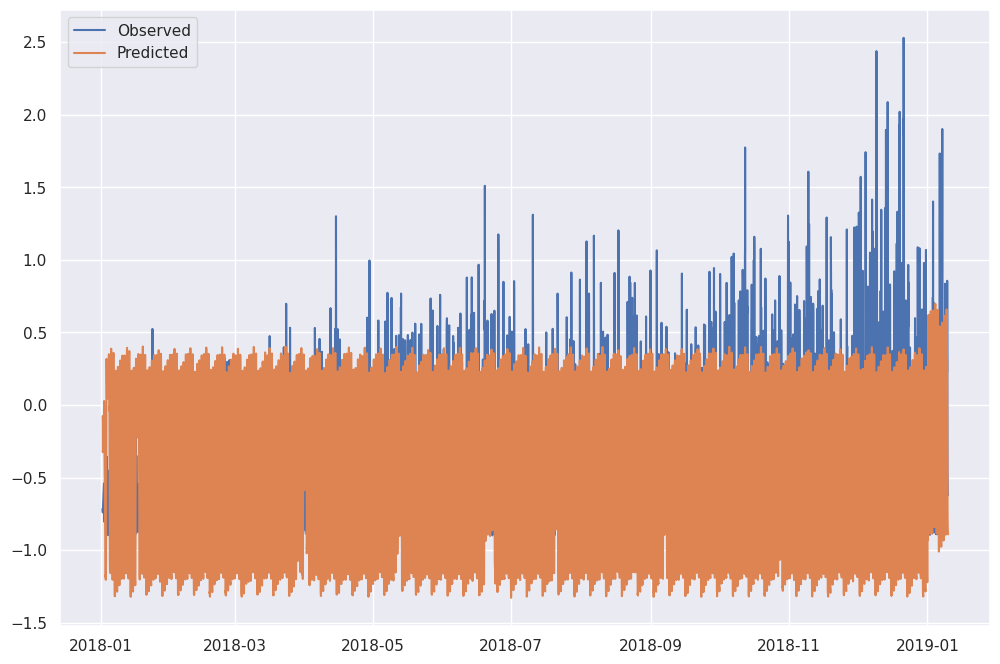

In [47]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(X.hour_date[:24*365], X.kWh_std[:24*365], label="Observed")
ax.plot(X.hour_date[:24*365], Y_obs[:24*365], label="Predicted")

ax.legend()

## Non-parametric

### Random Forest

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [31]:
rf = RandomForestRegressor()

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X[["year_idx", "hour", "day"]], X.kWh)

In [33]:
rf.fit(X_train, y_train)

RandomForestRegressor()

In [34]:
rf.score(X_train, y_train)

0.7252869169283953

In [35]:
rf.score(X_test, y_test)

0.6990217893718702

In [36]:
y_pred = rf.predict(X_train)

rmse = mean_squared_error(y_pred, y_train, squared=False)
print(f"RMSE (train):{rmse} kWh")

RMSE (train):9.073080695589695 kWh


In [37]:
y_pred = rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (test):{rmse} kWh")

RMSE (test):9.464378187796667 kWh
